In [1]:
from scipy.stats import unitary_group

import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map


from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [2]:
import numpy as np

## Random Dynamical Maps

This notebook generates random circuits to implement random dynamical maps, then executes them on IBMQ.

In [4]:
service = QiskitRuntimeService(channel="ibm_cloud")

In [5]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [6]:
backend = service.get_backend('ibm_kyoto')
# backend = service.least_busy(operational=True, simulator=False)

# backend = GenericBackendV2(16)

sampler = Sampler(backend=backend)

In [7]:
backend

<IBMBackend('ibm_kyoto')>

In [8]:
sampler.options.default_shots = 1024 * 4  # Options can be set using auto-complete.

In [9]:
backend.max_circuits

300

In [10]:
N = 15
D = 3

In [11]:
def construct():
    qc = QuantumCircuit(4, 3)

    for j in range(D):
        U = unitary_group.rvs(4)
        qc.unitary(U, [0,1])

        U = unitary_group.rvs(4)
        qc.unitary(U, [2,3])

        U = unitary_group.rvs(4)
        qc.unitary(U, [1,2])
    
    qc_out = QuantumCircuit(4, 3)
    for i in range(N):
        qc_out.compose(qc, inplace=True)
        qc_out.reset(0)
        qc_out.barrier()

    qc_out.measure([1,2,3], [0,1,2])
    # qc = transpile(qc, backend=backend, optimization_level=3)
    return qc_out

In [12]:
qc = [construct() for _ in range(100)]

In [13]:
qc = transpile(qc, backend=backend, optimization_level=3)

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuits = pm.run(qc)
# \n        Then pass `isa_circuits` to the Sampler or Estimator

In [15]:
# isa_circuits = [(a,) for a in isa_circuits]

In [17]:
active_qubits = set()
for instr, qargs, _ in isa_circuits[0].data:
    for q in qargs:
        active_qubits.add(q)

print(active_qubits)

{Qubit(QuantumRegister(127, 'q'), 45), Qubit(QuantumRegister(127, 'q'), 46), Qubit(QuantumRegister(127, 'q'), 43), Qubit(QuantumRegister(127, 'q'), 44)}


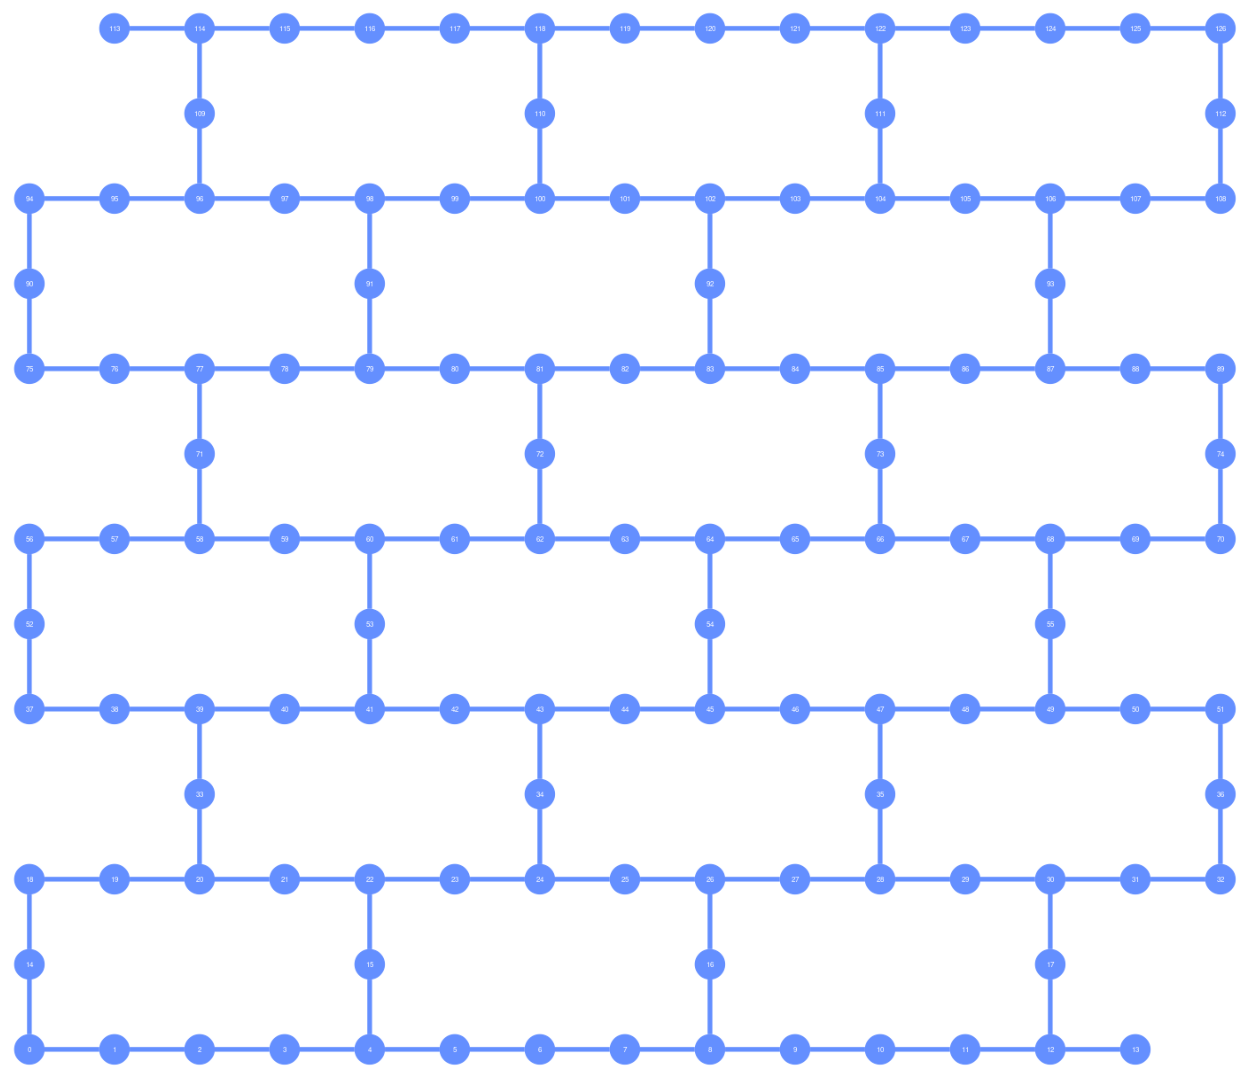

In [18]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend)

# Run on IBM Q

`circuit-runner` issue:
- Unable to retrieve job result. Error code 9605; Failed to load program into HAL component


`Sampler` issue:
- Circuits do not conform to the target definition (non-ISA circuits).

In [22]:
job = backend.run(isa_circuits, shots=1024*4)

/home/daniel/workspace/rand_channel/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: max_execution_time is not a recognized runtime option and may be ignored by the backend.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
result = job.result()

In [25]:
counts = result.get_counts()

In [26]:
shots = 1024 * 4

In [27]:
def counts_to_vec(counts):
    vals = dict(sorted(counts.int_outcomes().items())).values()
    return np.array(list(vals)) / shots

counts_vec = np.stack([counts_to_vec(c) for c in counts])

In [28]:
from scipy.stats import gamma

a = 16.76398344104434  # shape parameter (alpha)
scale = 0.007456461672107913  # scale parameter (theta)

# Create the gamma distribution
g = gamma(a, scale=scale)

xrange = np.linspace(0,0.5, 1000)

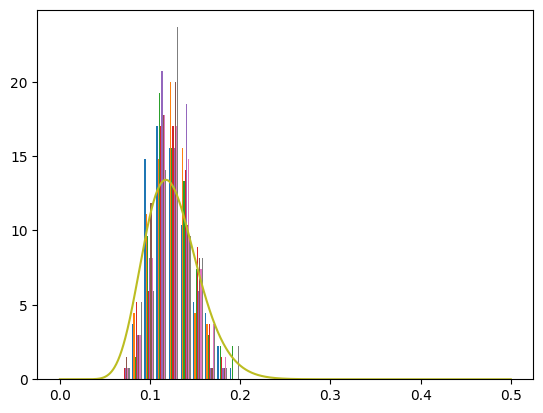

In [29]:
plt.hist(counts_vec, density=True)
plt.plot(xrange, g.pdf(xrange))